# Tutorial : Tensorflow-Keras Neural Networks

In a regression problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where we aim to predict a discrete label (for example, does this picture contain a cat or a dog).

This notebook builds a model to predict the median price of homes in a Boston suburb during the mid-1970s. To do this, we'll provide the model with some data points about the suburb, such as the crime rate and the local property tax rate.

We will use keras, an API built atop Tensorflow. Keras is a great place to start when learning neural-networks since it abstracts Tensorflow, is much easier to understand/learn, and allows you to do more with less code. For example, here is all the code needed define a fully connected feed-forward neural-net with two hidden layers:

```python
model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
```

This tutorial only scratches the surface of keras and tensorflow. I highly encourage you to read the [keras documentation pages](https://www.tensorflow.org/guide/keras)

** Source : **
Much of this tutorial is from https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_regression.ipynb

In [1]:
# packages used in this tutorial 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# 0. Cursory look at the data

Let's split the data into a training and testing set. At training time, we will hold a portion of the data for validation purposes. The model weights will be updated using the training data. During training the model will never see the test data. This will be used once the model is fully trained to evaluate how well the model performs on data it has never seen before

The dataset contains 13 different features:
1. Per capita crime rate.
2. The proportion of residential land zoned for lots over 25,000 square feet.
3. The proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. The average number of rooms per dwelling.
7. The proportion of owner-occupied units built before 1940.
8. Weighted distances to five Boston employment centers.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (M - 0.63) ** 2 where M is the proportion of minority by town.
13. Percentage lower status of the population.

Each one of these input data features is stored using a different scale. Some features are represented by a proportion between 0 and 1, other features are ranges between 1 and 12, some are ranges between 0 and 100, and so on. This is often the case with real-world data, and understanding how to explore and clean such data is an important skill to develop.

**Key Point:** As a modeler and developer, think about how this data is used and the potential benefits and harm a model's predictions can cause. A model like this could reinforce societal biases and disparities. Is a feature relevant to the problem you want to solve or will it introduce bias? For more information, read about [ML fairness](https://developers.google.com/machine-learning/fairness-overview/).

In [2]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (404, 13)
Testing set:  (102, 13)


In [3]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.12269,0.0,6.91,0.0,0.448,6.069,40.0,5.7209,3.0,233.0,17.9,389.39,9.55
1,2.37857,0.0,18.10,0.0,0.583,5.871,41.9,3.7240,24.0,666.0,20.2,370.73,13.34
2,14.05070,0.0,18.10,0.0,0.597,6.657,100.0,1.5275,24.0,666.0,20.2,35.05,21.22
3,41.52920,0.0,18.10,0.0,0.693,5.531,85.4,1.6074,24.0,666.0,20.2,329.46,27.38
4,1.51902,0.0,19.58,1.0,0.605,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32


## Labels

This is what we are trying to predict. 

In [4]:
print(train_labels[0:20])  # Display first 20 entries

[21.2 20.6 17.2  8.5 50.  36.5 20.5 24.4 41.3 19.2 13.3 33.2 18.5 19.
 16.3 19.4 20.6 13.2 18.7 13.8]


# 1. Creating a data pipeline
This consists on extracting the data (maybe from an external drive), transforming the data, and preparing it to load into the model. The `tf.data` API faciliate the transformation and loading portion of the data pipeline. However, When first learning keras I would start loading the data into the model as numpy arrays 

## 1.1 Transformation -- Normalize data

It's recommended to normalize features that use different scales and ranges. For each feature, subtract the mean of the feature and divide by the standard deviation

Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model more dependent on the choice of units used in the input.

Do not use any of the test data when making this calculation. The model can never see that data during training. We want that to be a completely independnt dataset

In [5]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std # (train_data - min) / (max-min) 
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-0.39249176 -0.48361547 -0.61656759 -0.25683275 -0.93348656 -0.27941779
 -1.03958208  0.97678588 -0.74135579 -1.04050111 -0.26209282  0.36817893
 -0.44038231]


# 2. Build the model

- hidden_layer_1 : 64 relu neurons
- hidden_layer_2 : 64 relu neurons
- output_layer   : 1 linear neuron

In [6]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(1024, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(1024, activation=tf.nn.relu,
                       name='hidden_layer_2',),
    keras.layers.Dense(1024, activation=tf.nn.relu,
                       name='hidden_layer_3',),
    #keras.layers.Dense(16, activation=tf.nn.relu,
    #                   input_shape=(16,),
    #                   name='hidden_layer_2',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae'])

# show a summary of the data
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 1024)              14336     
                                                                 
 hidden_layer_2 (Dense)      (None, 1024)              1049600   
                                                                 
 hidden_layer_3 (Dense)      (None, 1024)              1049600   
                                                                 
 output_layer (Dense)        (None, 1)                 1025      
                                                                 
Total params: 2,114,561
Trainable params: 2,114,561
Non-trainable params: 0
_________________________________________________________________


2022-10-19 17:59:19.325470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Train the model

The model is trained for 500 epochs, and record the training and validation accuracy in the history object.

In [7]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])


....................................................................................................
....

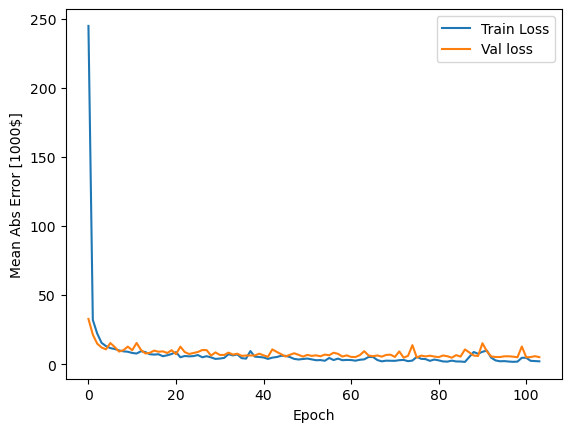

In [8]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

### What do you see?

This graph shows little improvement in the model after about 200 epochs. Let's update the `model.fit` method to automatically stop training when the validation score doesn't improve. We'll use a callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

The graph shows the average error is about \$2,500 dollars. Is this good? Well, \$2,500 is not an insignificant amount when some of the labels are only $15,000.
Let's see how did the model performs on the test set:

# 3. Evaluate on test data

In [9]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

Testing set Mean Abs Error: $2352.26


# 4. Predict (using test data)

Finally, predict some housing prices using data in the testing set:

4/4 [==============================] - 0s 4ms/step


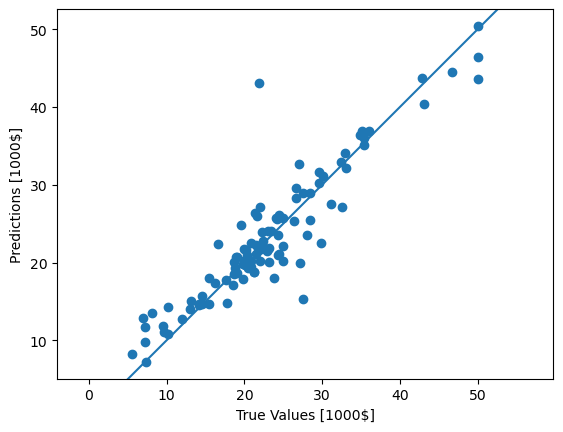

In [10]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [11]:
np.corrcoef(test_labels,test_predictions)[0,1]

0.9183766764699915

In [12]:
from sklearn.metrics import r2_score
r2_score(test_labels,test_predictions)

0.8419425268645286

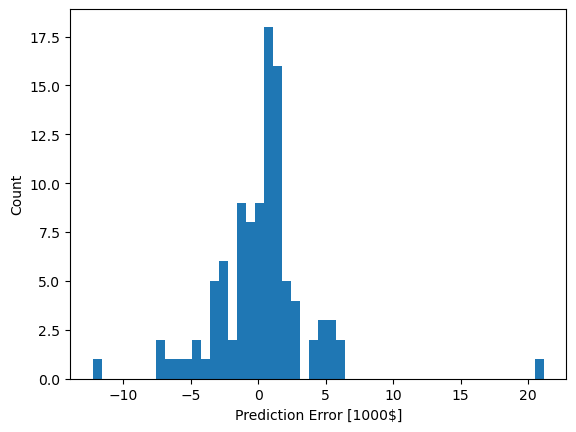

In [13]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
_ = plt.ylabel("Count")

## Conclusion

This notebook introduced a few techniques to handle a regression problem.
- Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
- Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
- When input data features have values with different ranges, each feature should be scaled independently.
- If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.
- Early stopping is a useful technique to prevent overfitting.